# 数据增强
<u>数据集：采用tensorflow自带数据集beans</u>

Beans 是使用智能手机相机在田间拍摄的豆类图像数据集。它由3个类别组成：2个疾病类别和健康类别。描述的疾病包括角叶斑病和豆锈病。数据由乌干达国家作物资源研究所 (NaCRRI) 的专家进行注释，并由 Makerere AI 研究实验室收集。

<u>basedon:https://tensorflow.google.cn/tutorials/images/data_augmentation</u>

----------------------------------
print(tfds.__version__) 版本4.5.2
添加代码，取消认证
获得 Google 身份 
**tfds.core.utils.gcs_utils._is_gcs_disabled = True**

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [74]:
# # 查看数据集
# tfds.list_builders()


In [75]:
# 下载数据集合
(train_ds,val_ds,test_ds),metadata = tfds.load(
    'beans',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True, 
    as_supervised=True

)

In [76]:
num_classes = metadata.features['label'].num_classes
print(num_classes)
# 数据集合的类别

3


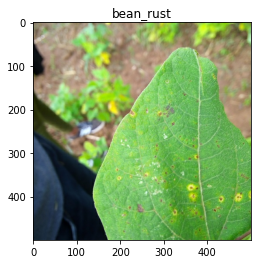

In [77]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

# 使用keras预处理层
1. 调整大小和重新缩放
2. 数据增强
3. 使用keras预处理的两个选项
4. 将预处理层应用于数据集
5. 训练模型
6. 自定义数据增强

In [78]:
'''调整大小和重新缩放'''
IMG_SIZE = 180
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1./255)
])

Min and max pixel values: 0.0 1.0


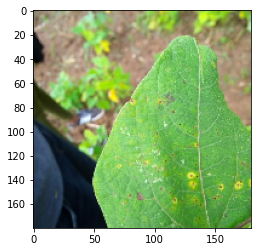

In [79]:
# 可视化
result = resize_and_rescale(image)
_ = plt.imshow(result)
# 验证像素是否在[0, 1]范围内：
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

In [80]:
'''数据增强'''
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

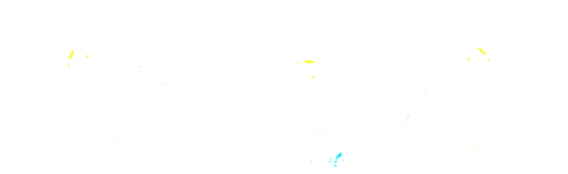

In [81]:
# 可视化
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)
plt.figure(figsize=(10, 10))
for i in range(3):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [82]:
'''使用keras预处理层---选项一：使预处理成为模型的一部分'''
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16,3,padding="same",activation='relu'),
    layers.MaxPooling2D(),


    # 剩下的模型结构
    #在这种情况下，有两点需要注意：

    # 1. 数据增强将在设备上运行，与您的其余层同步，并受益于 GPU 加速。

    # 2. 当您使用 导出模型model.save时，预处理层将与模型的其余部分一起保存。
    # 如果您稍后部署此模型，它将自动标准化图像（根据您的层的配置）。
    # 这可以使您不必重新实现该逻辑服务器端的工作。
# ])

'使用keras预处理层---选项一：使预处理成为模型的一部分'

In [83]:
'''使用keras预处理层---选项二：将预处理层应用于您的数据集'''
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))
# 使用这种方法，您Dataset.map可以创建一个数据集，该数据集会产生成批的增强图像。在这种情况下：
  # 1.数据扩充将在 CPU 上异步发生，并且是非阻塞的。
  # 您可以使用数据预处理在 GPU 上对模型的训练进行重叠Dataset.prefetch

  # 2.在这种情况下，当您调用Model.save. 在保存模型或在服务器端重新实现它们之前
  #，您需要将它们附加到模型中。训练后，您可以在导出前附加预处理层。

'使用keras预处理层---选项一：将预处理层应用于您的数据集'

In [84]:
'''将预处理层应用于数据集'''
batch_size = 32
# 数据接口
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
 # .map可以创建一个数据集，该数据集会产生成批的增强图像.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

# 多个批次取数据集
  ds = ds.batch(batch_size)

# 只在训练集上使用数据增强
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # 在所有數據集上使用緩衝預取。
  return ds.prefetch(buffer_size=AUTOTUNE)

In [85]:
# 下载数据集，重新准备数据
# (train_ds,val_ds,test_ds),metadata = tfds.load(
#     'tf_flowers',
#     split=['train[:80%]','train[80%:90%]','train[90%:]'],
#     with_info=True,
#     as_supervised=True
# )
# 在训练集上进行数据增强和打乱顺序
train_ds = prepare(train_ds,shuffle=True,augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)


In [86]:
'''训练模型'''
model = tf.keras.Sequential([
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  
  layers.Dense(num_classes)
])
# model.summary()

In [87]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [88]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
26/26 [==============================] - 6s 116ms/step - loss: 1.0761 - accuracy: 0.3978 - val_loss: 1.2458 - val_accuracy: 0.3077
Epoch 2/10
26/26 [==============================] - 4s 102ms/step - loss: 1.0990 - accuracy: 0.3676 - val_loss: 1.0206 - val_accuracy: 0.4808
Epoch 3/10
26/26 [==============================] - 4s 104ms/step - loss: 0.9660 - accuracy: 0.5151 - val_loss: 0.8779 - val_accuracy: 0.6635
Epoch 4/10
26/26 [==============================] - 4s 104ms/step - loss: 0.9095 - accuracy: 0.5574 - val_loss: 0.8751 - val_accuracy: 0.6442
Epoch 5/10
26/26 [==============================] - 4s 103ms/step - loss: 0.8687 - accuracy: 0.5901 - val_loss: 0.7578 - val_accuracy: 0.6923
Epoch 6/10
26/26 [==============================] - 4s 103ms/step - loss: 0.8425 - accuracy: 0.6131 - val_loss: 0.7669 - val_accuracy: 0.6442
Epoch 7/10
26/26 [==============================] - 4s 104ms/step - loss: 0.7723 - accuracy: 0.6566 - val_loss: 0.7724 - val_accuracy: 0.6346
Epoch 

In [89]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

4/4 [==============================] - 0s 66ms/step - loss: 0.7563 - accuracy: 0.6699
Accuracy 0.6699029207229614


In [90]:
'''自定义数据增强'''
# 对比度等的变化
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x
# 形状的变化，比如旋转
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))


TypeError: ignored

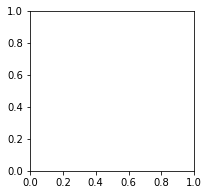

In [94]:
# plt.figure(figsize=(10, 10))
# for i in range(9):
#   augmented_image = random_invert(image)
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(augmented_image[0].numpy().astype("uint8"))
#   plt.axis("off")
# error:
# TypeError: 'Lambda' object is not subscriptable

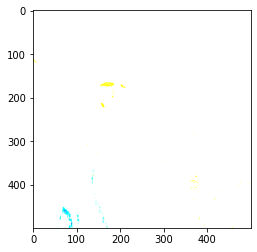

In [92]:
'''
还可以通过子类化来实现数据增强
'''
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)
_ = plt.imshow(RandomInvert()(image)[0])